In [2]:
!pip install tensorflow_text

     |████████████████████████████████| 4.6 MB 8.5 MB/s 
     |████████████████████████████████| 511.7 MB 4.0 kB/s 
     |████████████████████████████████| 5.8 MB 56.4 MB/s 
     |████████████████████████████████| 1.6 MB 55.6 MB/s 
     |████████████████████████████████| 438 kB 69.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: flatbuffers
  

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

In [5]:
df = pd.read_csv('/content/email.csv')

In [6]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.shape

(5573, 2)

In [10]:
df['Category'].value_counts()

ham               4825
spam               747
{"mode":"full"       1
Name: Category, dtype: int64

In [15]:
df_spam = df[df['Category'] == 'spam']

In [16]:
df_ham = df[df['Category'] == 'ham']

In [17]:
df_ham.shape

(4825, 2)

In [18]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])

In [19]:
df_ham_downsampled.shape

(747, 2)

In [21]:
df_dataset = pd.concat([df_ham_downsampled,df_spam])
df_dataset.shape

(1494, 2)

In [22]:
df_dataset['spam']=df_dataset['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_dataset.sample(5)

,Category,Message,spam
3299,spam,This message is free. Welcome to the new & imp...,1
5007,ham,ILL B DOWN SOON,0
4794,ham,Or u ask they all if next sat can a not. If al...,0
579,spam,"our mobile number has won £5000, to claim call...",1
576,spam,"You have won ?1,000 cash or a ?2,000 prize! To...",1


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_dataset['Message'],df_dataset['spam'], stratify=df_dataset['spam'])

In [24]:
X_train.head()

2507                                 Who u talking about?
314     Hi the way I was with u 2day, is the normal wa...
4279                         I've reached home finally...
4949    Hi this is Amy, we will be sending you a free ...
3801    We tried to contact you re your reply to our o...
Name: Message, dtype: object

In [25]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [26]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.51327276, -0.88845724, ..., -0.74748844,
        -0.7531474 ,  0.91964495],
       [-0.87208337, -0.5054394 , -0.94446665, ..., -0.85847497,
        -0.71745324,  0.8808295 ]], dtype=float32)>

In [27]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

**Build Model**

In [29]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [31]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [32]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 20s 299ms/step - loss: 0.6167 - accuracy: 0.6777 - precision: 0.6701 - recall: 0.7000
Epoch 2/10
35/35 [==============================] - 11s 301ms/step - loss: 0.4952 - accuracy: 0.8134 - precision: 0.8021 - recall: 0.8321
Epoch 3/10
35/35 [==============================] - 11s 302ms/step - loss: 0.4496 - accuracy: 0.8286 - precision: 0.8206 - recall: 0.8411
Epoch 4/10
35/35 [==============================] - 11s 303ms/step - loss: 0.4014 - accuracy: 0.8723 - precision: 0.8492 - recall: 0.9054
Epoch 5/10
35/35 [==============================] - 11s 304ms/step - loss: 0.3819 - accuracy: 0.8750 - precision: 0.8559 - recall: 0.9018
Epoch 6/10
35/35 [==============================] - 11s 305ms/step - loss: 0.3593 - accuracy: 0.8786 - precision: 0.8706 - recall: 0.8893
Epoch 7/10
35/35 [==============================] - 11s 307ms/step - loss: 0.3356 - accuracy: 0.8884 - precision: 0.8744 - recall: 0.9071
Epoch 8/10
35/35 [================

In [33]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 5s 317ms/step


In [34]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[171,  16],
       [ 11, 176]])

Text(33.0, 0.5, 'Truth')

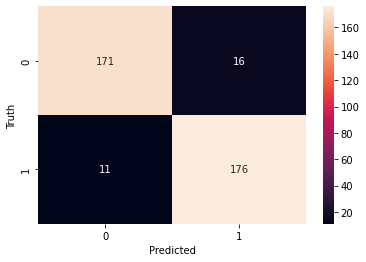

In [36]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')